In [4]:
from model import Experiment
from util import collate_padded_tuples, markdown_format_code

import torch
import librosa
import soundfile

In [5]:
exp = Experiment(logdir="./logs/ft/")
exp.model.load_state_dict(torch.load('./logs/ssvqvae_model_state.pt', map_location=exp.device))

/tmp/ipykernel_3664/3165332233.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  exp.model.load_state_dict(torch.load('./logs/ssvqvae_model_state.pt', map_location=exp.dev

<All keys matched successfully>

In [6]:
with torch.utils.tensorboard.SummaryWriter(log_dir=exp.logdir) as tb_writer:
        tb_writer.add_text("model", markdown_format_code(repr(exp.model)))
        print(markdown_format_code(repr(exp.model)))
        exp.model.train(True)
        

        loader_train = torch.utils.data.DataLoader(
            batch_size=16,
            num_workers=8,
            dataset=exp._get_dataset("train", lazy=True),
            collate_fn=collate_padded_tuples,
            shuffle=True,
        )

        loader_val = torch.utils.data.DataLoader(
            batch_size=16,
            num_workers=8,
            dataset=exp._get_dataset("val", lazy=True),
            collate_fn=collate_padded_tuples,
        )

        num_epochs = 4
        val_period = 50
        log_period = 1
        sample_period = 2

        i = 0
        for epoch in range(num_epochs):
            print(f"Starting epoch {epoch + 1} / {num_epochs}")
            for (input_c, length_c), (input_s, length_s) in loader_train:
                input_c, length_c, input_s, length_s = (
                    x.to(exp.device)
                    for x in (input_c, length_c, input_s, length_s)
                )

                # Validation
                if i % val_period == 0:
                    with torch.no_grad():
                        print("Starting validation at step ", i)
                        exp._validate(
                            loader=loader_val,
                            tb_writer=tb_writer,
                            step=i,
                            write_samples=(i // val_period) % sample_period == 0,
                            write_model=True,
                        )
                        print("Validation done")

                # Forward pass
                if not exp.model.training:
                    exp.model.train(True)
                _, losses = exp.model(
                    input_c, input_s, length_c, length_s, return_losses=True
                )
                exp._add_total_loss(losses, step=i)

                # Logging
                if i % log_period == 0:
                    for name, loss in losses.items():
                        tb_writer.add_scalar(f"loss_train/{name}", loss, i)

                    for dev_idx in range(torch.cuda.device_count()):
                        tb_writer.add_scalar(
                            f"mem/cuda:{dev_idx}",
                            torch.cuda.memory_allocated(dev_idx),
                            i,
                        )

                # Backward pass
                exp.optimizer.zero_grad()
                losses["total"].backward(retain_graph=True)
                if i % log_period == 0:
                    exp._log_params(tb_writer, i)
                exp.optimizer.step()

                i += 1

            print(f"Epoch {epoch + 1} finished ({i} steps)")

    Model(
      (content_encoder): Sequential(
        (0): Conv1d(1025, 1024, kernel_size=(4,), stride=(2,), padding=(2,))
        (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): Conv1d(1024, 1024, kernel_size=(4,), stride=(2,), padding=(2,))
        (4): ResidualWrapper(
          (module): Sequential(
            (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): LeakyReLU(negative_slope=0.1)
            (2): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
          )
        )
        (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (vq): VQEmbedding(
        (embedding): Embedding(2048, 1024)
      )
      (style_encoder_1d): Sequential(
        (0): Conv1d(1025, 1024, kernel_size=(4,), stride=(2,))
        (1): ResidualWrapper(
          (module): Sequential(
            (0): Batc

In [7]:
exp.model.train(False)

Model(
  (content_encoder): Sequential(
    (0): Conv1d(1025, 1024, kernel_size=(4,), stride=(2,), padding=(2,))
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv1d(1024, 1024, kernel_size=(4,), stride=(2,), padding=(2,))
    (4): ResidualWrapper(
      (module): Sequential(
        (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): LeakyReLU(negative_slope=0.1)
        (2): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,))
      )
    )
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (vq): VQEmbedding(
    (embedding): Embedding(2048, 1024)
  )
  (style_encoder_1d): Sequential(
    (0): Conv1d(1025, 1024, kernel_size=(4,), stride=(2,))
    (1): ResidualWrapper(
      (module): Sequential(
        (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): L

In [13]:
a_content, _ = librosa.load("./examples/content_2.mp3", sr=exp.sr)
a_style, _ = librosa.load("./examples/style_2.mp3", sr=exp.sr)

In [14]:
s_content = torch.as_tensor(exp.preprocess(a_content), device=exp.device)[None, :]
s_style = torch.as_tensor(exp.preprocess(a_style), device=exp.device)[None, :]
l_content, l_style = (torch.as_tensor([x.shape[2]], device=exp.device) for x in [s_content, s_style])
with torch.no_grad():
    s_output = exp.model(input_c=s_content, input_s=s_style,
                         length_c=l_content, length_s=l_style)
a_output = exp.postprocess(s_output.cpu().numpy()[0])

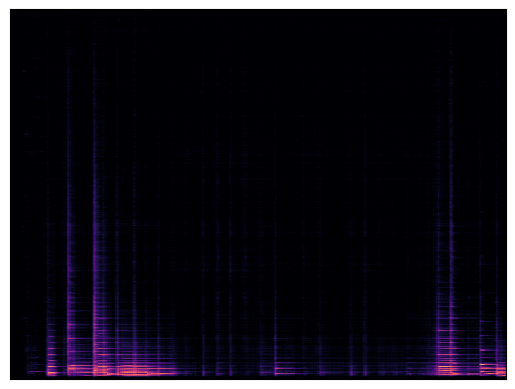

In [15]:
librosa.display.specshow(s_output.cpu().numpy()[0])

In [16]:
soundfile.write("./examples/out_ft_2.mp3", a_output , exp.sr)